<a href="https://colab.research.google.com/github/melyneca/shipstuff/blob/main/Ship_Classify_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Önce uygun kütüphaneler yüklenir


In [1]:
import torch
import torchvision.transforms as transforms
import pandas as pd
import os
from torch.utils.data import Dataset
from skimage import io
import torchvision
import numpy as np
import torch.nn as nn


Zip dosyası açılır ve extractall() ile dosyalar dışarı çıkarılır

In [ ]:
from zipfile import ZipFile
  
# Zip file directory
file_name = "/content/archive (1).zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # extracting all the files
    zip.extractall()

In [49]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [50]:
class ShipLoad(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
    image = io.imread(img_path)
    y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

    if self.transform:
      image = self.transform(image)

    return (image, y_label)

In [51]:
transform= transforms.Compose(
        [transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((64,64)),
        transforms.ToTensor()
        ])

In [53]:
train_set = ShipLoad('/content/train/train.csv', root_dir ='/content/train/images', transform = transform)
test_set = ShipLoad('/content/train/train.csv', root_dir ='/content/train/images', transform = transform)

In [54]:
classes = ['Cargo','Military','Carrier','Cruise','Tankers']

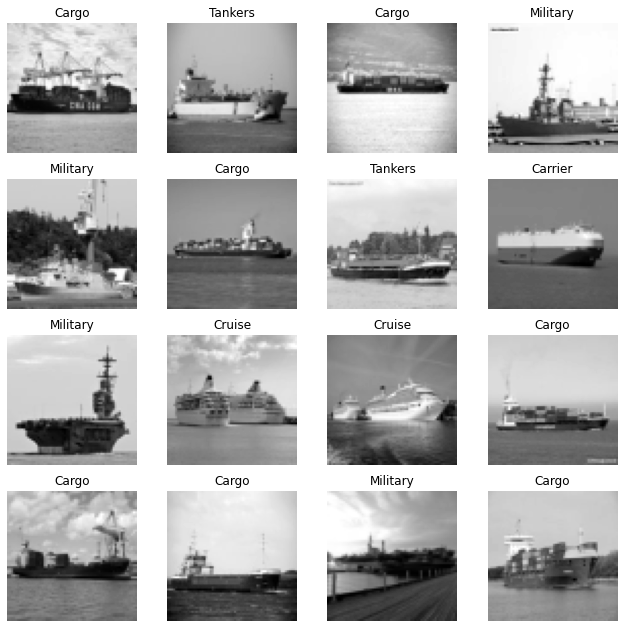

In [55]:
import matplotlib.pyplot as plt
import random

fig = plt.figure(figsize=(11,11))

for i in range(1,17):
  id = random.randint(0,len(train_set))
  images, label = train_set[id] 
  fig.add_subplot(4, 4, i)
  plt.imshow(images.squeeze(), cmap = 'gray')
  plt.axis('off');
  plt.title(classes[label-1]);


In [56]:
from torch.utils.data import DataLoader

DataLoadder kullanılarak resimler batchler halinde yüklenir


In [57]:
train_data = DataLoader(dataset = train_set, batch_size= 32, shuffle= True)
test_data = DataLoader(dataset = test_set, batch_size= 32)



In [58]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [59]:
class ModelEasy(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, out_shape: int):
    super().__init__()
    self.layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features= hidden_units),
        nn.Linear(in_features=hidden_units, out_features= out_shape)
    )
  def forward(self,x):
    return self.layer(x)

In [63]:
model1 = ModelEasy(input_shape=64*64, hidden_units= 30, out_shape= 5)
model1

ModelEasy(
  (layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=5, bias=True)
  )
)

In [62]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.1)


In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  ### Training
  train_loss = 0

  # Add a loop to loop through training batches
  for batch, (X, y) in enumerate(train_data):
    X, y = X.to(device), y.to(device)
    model1.train() 
      # 1. Forward pass
    y_pred = model1(X)

      # 2. Calculate loss (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulatively add up the loss per epoch 

      # 3. Optimizer zero grad
    optimizer.zero_grad()

      # 4. Loss backward
    loss.backward()

      # 5. Optimizer step
    optimizer.step()

  # Divide total train loss by length of train dataloader (average loss per batch per epoch)
  train_loss /= len(train_data)   
